In [9]:
scanpath="/home/michele/Desktop/Colombo/Scannet/scans/scene0002_00/"

In [ ]:
import pandas as pd

# Load your mapping file (tab-separated)
df = pd.read_csv(scanpath+"scannetv2-labels.combined.tsv", sep="\t")

# Create id to class name mapping (e.g., from `id` to `nyuClass` or `category`)
id_to_name = dict(zip(df["nyu40id"], df["nyuClass"]))  # or "nyuClass"


In [6]:
len(id_to_name)

40

In [10]:
import imageio

label = imageio.v2.imread(scanpath+"label_nyu40/0.png")

# Get unique class IDs in the label image
unique_classes = set(label.flatten())

for cls_id in sorted(unique_classes):
    print(f"Class {cls_id}: {id_to_name.get(cls_id, 'Unknown')}")

Class 0: Unknown
Class 1: wall
Class 2: floor
Class 3: cabinet
Class 5: chair
Class 6: sofa
Class 8: door
Class 18: pillow
Class 39: nan
Class 40: cup


# Creating folder structure for training

In [14]:
import os
import shutil
import random
from pathlib import Path


rgb_dir=scanpath+"color"         # Folder with .jpg images
label_dir=scanpath+"label_nyu40"     # Folder with .png grayscale masks
output_dir="output_db"         # Output dataset folder
train_pct=0.7
val_pct=0.2
test_pct=0.1


rgb_dir = Path(rgb_dir)
label_dir = Path(label_dir)
output_dir = Path(output_dir)

# Get matching image/label file names
image_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith(".jpg")])
label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])

assert len(image_files) == len(label_files), "Number of images and labels must match"
assert all(os.path.splitext(i)[0] == os.path.splitext(l)[0] for i, l in zip(image_files, label_files)), "Filenames don't match"

# Shuffle consistently
paired = list(zip(image_files, label_files))
random.shuffle(paired)

n_total = len(paired)
n_train = int(train_pct * n_total)
n_val = int(val_pct * n_total)

train_set = paired[:n_train]
val_set = paired[n_train:n_train+n_val]
test_set = paired[n_train+n_val:]

splits = {
    "train": train_set,
    "val": val_set,
    "test": test_set
}

# Create directory structure
for subfolder in ["images", "labels"]:
    for split in splits:
        path = output_dir / subfolder / split
        path.mkdir(parents=True, exist_ok=True)

# Copy files
for split, items in splits.items():
    for img_name, lbl_name in items:
        shutil.copy(rgb_dir / img_name, output_dir / "images" / split / img_name)
        shutil.copy(label_dir / lbl_name, output_dir / "labels" / split / lbl_name)

print(f"✅ Split complete! {n_total} files -> {n_train} train, {n_val} val, {len(test_set)} test.")
   


✅ Split complete! 5193 files -> 3635 train, 1038 val, 520 test.


# Train

In [1]:
import torch

print("Torch version:", torch.__version__)
print("CUDA disponibile:", torch.cuda.is_available())
print("Versione CUDA supportata da PyTorch:", torch.version.cuda)
print("Numero di GPU:", torch.cuda.device_count())
print("Nome GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Nessuna GPU trovata")
print("Dispositivo corrente:", torch.cuda.current_device() if torch.cuda.is_available() else "N/A")


Torch version: 2.4.1+cu121
CUDA disponibile: True
Versione CUDA supportata da PyTorch: 12.1
Numero di GPU: 1
Nome GPU: NVIDIA GeForce RTX 3060 Ti
Dispositivo corrente: 0


In [7]:

torch.cuda.empty_cache()       # Clears unused memory from the GPU cache
torch.cuda.ipc_collect()       # Collects inter-process memory (useful if you're restarting processes)

In [8]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm import tqdm

# ==== Config Parameters ====
EPOCHS = 20
BATCH_SIZE = 4
PATIENCE = 5
IMAGE_SIZE =  (480, 640)  # (Height, Width)

# ==== Custom Dataset ====
class NYU40SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.label_dir = Path(label_dir)
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
        self.labels = sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])
        self.transform = transform

        assert len(self.images) == len(self.labels), "Mismatch in image and label count"
        assert all(os.path.splitext(i)[0] == os.path.splitext(l)[0] for i, l in zip(self.images, self.labels)), "Mismatch in filenames"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.image_dir / self.images[idx]
        label_path = self.label_dir / self.labels[idx]

        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path)

        image = self.transform(image) if self.transform else T.ToTensor()(image)
        label = torch.from_numpy(np.array(label)).long()

        return image, label

# ==== Transforms ====
transform = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.ToTensor()
])

# ==== Paths ====
root = Path("output_db")
train_dataset = NYU40SegmentationDataset(root / "images/train", root / "labels/train", transform)
val_dataset   = NYU40SegmentationDataset(root / "images/val", root / "labels/val", transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ==== Model ====
NUM_CLASSES = 40  # NYU40
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.cuda()

# ==== Loss and Optimizer ====
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ==== Training with Early Stopping ====
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}"):
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = model(imgs)['out']

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model(imgs)['out']
            val_loss += criterion(outputs, labels).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"🔍 Val Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "deeplabv3_nyu40.pth")
        print("💾 Model improved. Saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

print("✅ Training complete.")


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.94 GiB total capacity; 2.66 GiB already allocated; 29.00 MiB free; 2.67 GiB reserved in total by PyTorch)

In [ ]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Load the test set
test_dataset = NYU40SegmentationDataset(root / "images/test", root / "labels/test", transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Put the model in eval mode
model.eval()

# Inference loop
with torch.no_grad():
    for idx, (img, label) in enumerate(test_loader):
        img = img.cuda()
        output = model(img)['out']
        pred = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()

        # Save or visualize the prediction
        pred_image = Image.fromarray(pred.astype(np.uint8))
        pred_image.save(f"predictions/test_{idx}.png")

        # Optional: save original RGB for comparison
        TF.to_pil_image(img.cpu().squeeze()).save(f"predictions/test_{idx}_rgb.jpg")

        if idx < 5:  # display a few examples
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.imshow(TF.to_pil_image(img.cpu().squeeze()))
            plt.title("RGB")

            plt.subplot(1,3,2)
            plt.imshow(label.squeeze().cpu(), cmap="gray")
            plt.title("Ground Truth")

            plt.subplot(1,3,3)
            plt.imshow(pred, cmap="gray")
            plt.title("Prediction")

            plt.show()


# FROM CHECKPOINT

In [3]:
import torch
import torchvision

In [1]:
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Function to strip the prefix from the checkpoint state dict
def strip_prefix(state_dict, prefix):
    return {
        (k[len(prefix):] if k.startswith(prefix) else k): v
        for k, v in state_dict.items()
    }

# Load the pre-trained model
model = torchvision.models.segmentation.deeplabv3_resnet101(
    pretrained=False,
    pretrained_backbone=True,
    progress=True,
    num_classes=40,  # Update this based on your dataset
    aux_loss=None,
)

# Load checkpoint
checkpoint = torch.load("Models/best-epoch143-step175536.ckpt", map_location='cpu')

# If checkpoint is a state_dict directly
checkpoint = checkpoint["state_dict"]

# Remove any aux classifier stuff
removekeys = [key for key in checkpoint.keys() if key.startswith("_model._model.aux_classifier")]
for key in removekeys:
    del checkpoint[key]

# Strip the prefix from the checkpoint keys
checkpoint = strip_prefix(checkpoint, "_model._model.")

# Load the model weights into the model
model.load_state_dict(checkpoint, strict=False)

# Set the model to evaluation mode
model.eval()
torch.save(model.state_dict(), "Models/deeplabv3.pth")
print("Saved cleaned model to Models/deeplabv3_cleaned.pth")



d:\CODING_UTILITY\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\CODING_UTILITY\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
d:\CODING_UTILITY\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
d:\CODING_UTILITY\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is eq

Saved cleaned model to Models/deeplabv3_cleaned.pth


In [3]:
for k in list(checkpoint.keys()):
    print(k)

backbone.conv1.weight
backbone.bn1.weight
backbone.bn1.bias
backbone.bn1.running_mean
backbone.bn1.running_var
backbone.bn1.num_batches_tracked
backbone.layer1.0.conv1.weight
backbone.layer1.0.bn1.weight
backbone.layer1.0.bn1.bias
backbone.layer1.0.bn1.running_mean
backbone.layer1.0.bn1.running_var
backbone.layer1.0.bn1.num_batches_tracked
backbone.layer1.0.conv2.weight
backbone.layer1.0.bn2.weight
backbone.layer1.0.bn2.bias
backbone.layer1.0.bn2.running_mean
backbone.layer1.0.bn2.running_var
backbone.layer1.0.bn2.num_batches_tracked
backbone.layer1.0.conv3.weight
backbone.layer1.0.bn3.weight
backbone.layer1.0.bn3.bias
backbone.layer1.0.bn3.running_mean
backbone.layer1.0.bn3.running_var
backbone.layer1.0.bn3.num_batches_tracked
backbone.layer1.0.downsample.0.weight
backbone.layer1.0.downsample.1.weight
backbone.layer1.0.downsample.1.bias
backbone.layer1.0.downsample.1.running_mean
backbone.layer1.0.downsample.1.running_var
backbone.layer1.0.downsample.1.num_batches_tracked
backbone.lay

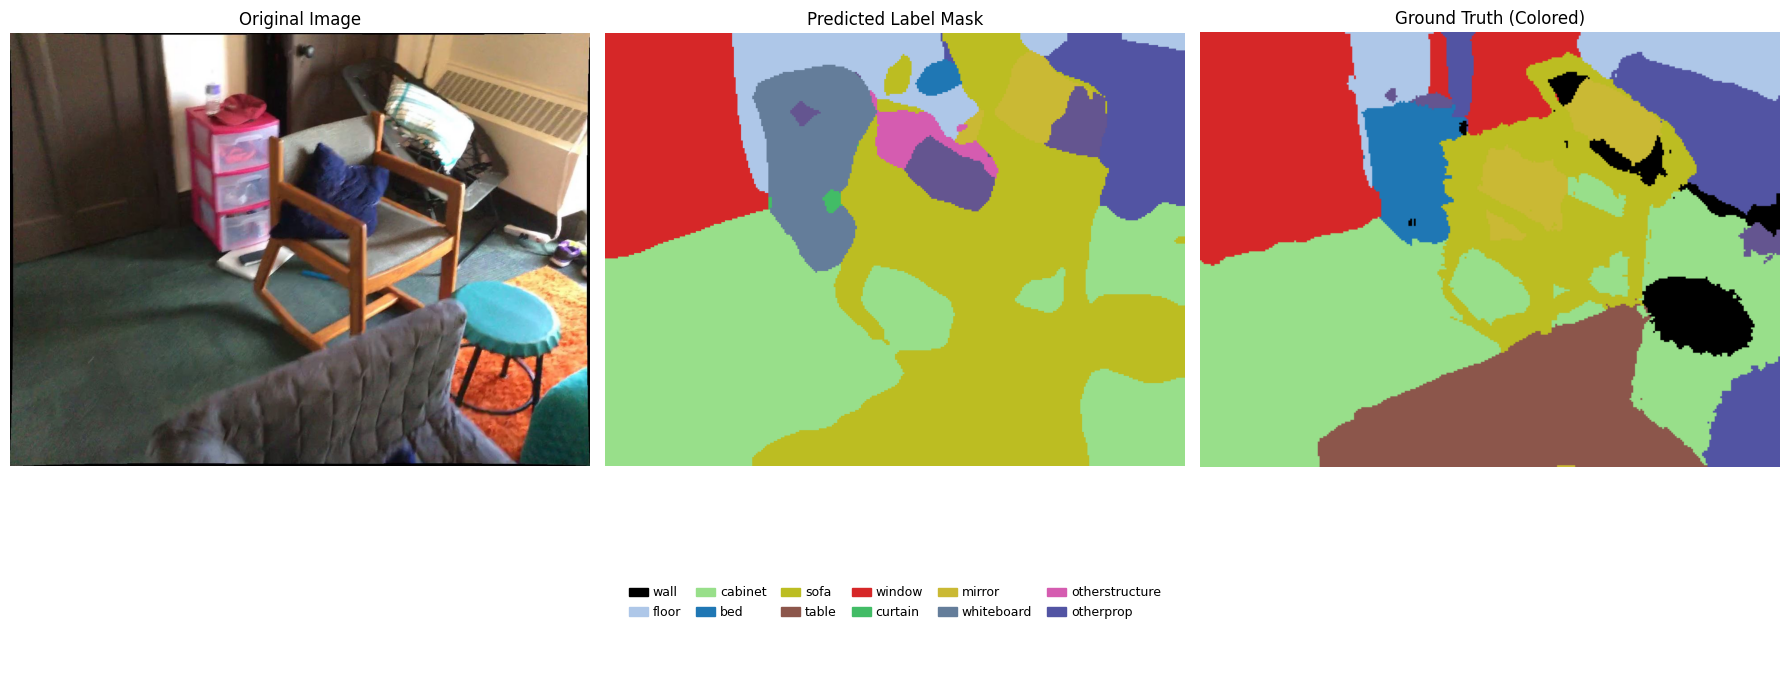

Mean IoU (mIoU): 0.1710


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2  # For resizing and smoothing
import torchvision.transforms as T
import torchvision.transforms.functional as F

# Load segmentation color mapping
mapping = np.genfromtxt("./Test/nyu40_segmentation_mapping.csv", delimiter=",")
class_colors = mapping[1:, 1:4].astype(np.uint8)

# Target crop size (matches training)
target_size = (240, 320)

# Preprocess function that mimics training's inference logic
def preprocess_ucsa(img, target_size=(240, 320)):
    img_tensor = F.to_tensor(img)  # [C, H, W]

    H, W = img_tensor.shape[1:]
    sf1 = float(target_size[0] / H) * 1.2
    sf2 = float(target_size[1] / W) * 1.2
    sf = max(sf1, sf2)

    if H >= 2 * target_size[0] or H < target_size[0] or W < target_size[1]:
        img_tensor = torch.nn.functional.interpolate(
            img_tensor[None],
            scale_factor=(sf, sf),
            mode="bilinear",
            align_corners=False
        )[0]

    img_tensor = F.center_crop(img_tensor, target_size)
    return img_tensor.unsqueeze(0)  # Add batch dimension

# Load image
img_path = "./Test/9.jpg"
img = Image.open(img_path).convert("RGB")

# Apply correct preprocessing
img_tensor = preprocess_ucsa(img, target_size)

# Inference
with torch.no_grad():
    output = model(img_tensor)

# Post-process predictions
output_predictions = output['out'][0]
output_predictions = torch.argmax(output_predictions, dim=0)
output_predictions = output_predictions.cpu().numpy()
output_predictions p= 1
# Convert label map to RGB using class_colors
rgb_output = np.zeros((output_predictions.shape[0], output_predictions.shape[1], 3), dtype=np.uint8)
for class_id, color in enumerate(class_colors):
    rgb_output[output_predictions == class_id] = color

# Resize to original image resolution
rgb_output_resized = cv2.resize(rgb_output, (img.size[0], img.size[1]), interpolation=cv2.INTER_NEAREST)

# Load and rotate GT mask (assumed grayscale with label IDs)
gt_path = "./Test/9.png"  # Adjust path if needed
gt = Image.open(gt_path).convert("L")
#gt = gt.rotate(-90, expand=True)  # Rotate to fix orientation

# Resize GT to match target size
gt_resized = gt.resize((target_size[1], target_size[0]), Image.NEAREST)
gt_np = np.array(gt_resized)

# Color GT using class_colors
gt_rgb = np.zeros((gt_np.shape[0], gt_np.shape[1], 3), dtype=np.uint8)
for class_id, color in enumerate(class_colors):
    gt_rgb[gt_np == class_id] = color

import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import pandas as pd

# Get unique labels in prediction and GT
unique_pred_labels = np.unique(output_predictions)
unique_gt_labels = np.unique(gt_np)
unique_labels = np.unique(np.concatenate([unique_pred_labels, unique_gt_labels]))

# Load label names from CSV
df = pd.read_csv("./Test/nyu40_segmentation_mapping.csv")
label_names = df["name"].values[1:]  # skip header/unlabeled
label_colors = class_colors  # shape: (40, 3)

# Build patches only for labels present
legend_patches = [
    mpatches.Patch(color=label_colors[i] / 255.0, label=label_names[i])
    for i in unique_labels if i < len(label_names)
]

# Set up grid layout with space for legend
fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[5, 1])  # 2 rows, 3 columns

# Display original image
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(np.array(img))
ax0.set_title("Original Image")
ax0.axis('off')

# Display prediction
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(rgb_output_resized)
ax1.set_title("Predicted Label Mask")
ax1.axis('off')

# Display ground truth
ax2 = fig.add_subplot(gs[0, 2])
ax2.imshow(gt_rgb)
ax2.set_title("Ground Truth (Colored)")
ax2.axis('off')

# Legend below
ax_legend = fig.add_subplot(gs[1, :])
ax_legend.axis('off')
legend = ax_legend.legend(
    handles=legend_patches,
    loc='center',
    ncol=6,
    fontsize=9,
    handlelength=1.5,
    handletextpad=0.4,
    columnspacing=1.2,
    frameon=False
)
fig.tight_layout()
plt.show()

# Compute mIoU
def compute_miou(pred, target, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            ious.append(np.nan)  # Ignore if class doesn't appear
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

miou = compute_miou(output_predictions, gt_np, num_classes=len(class_colors))
print(f"Mean IoU (mIoU): {miou:.4f}")


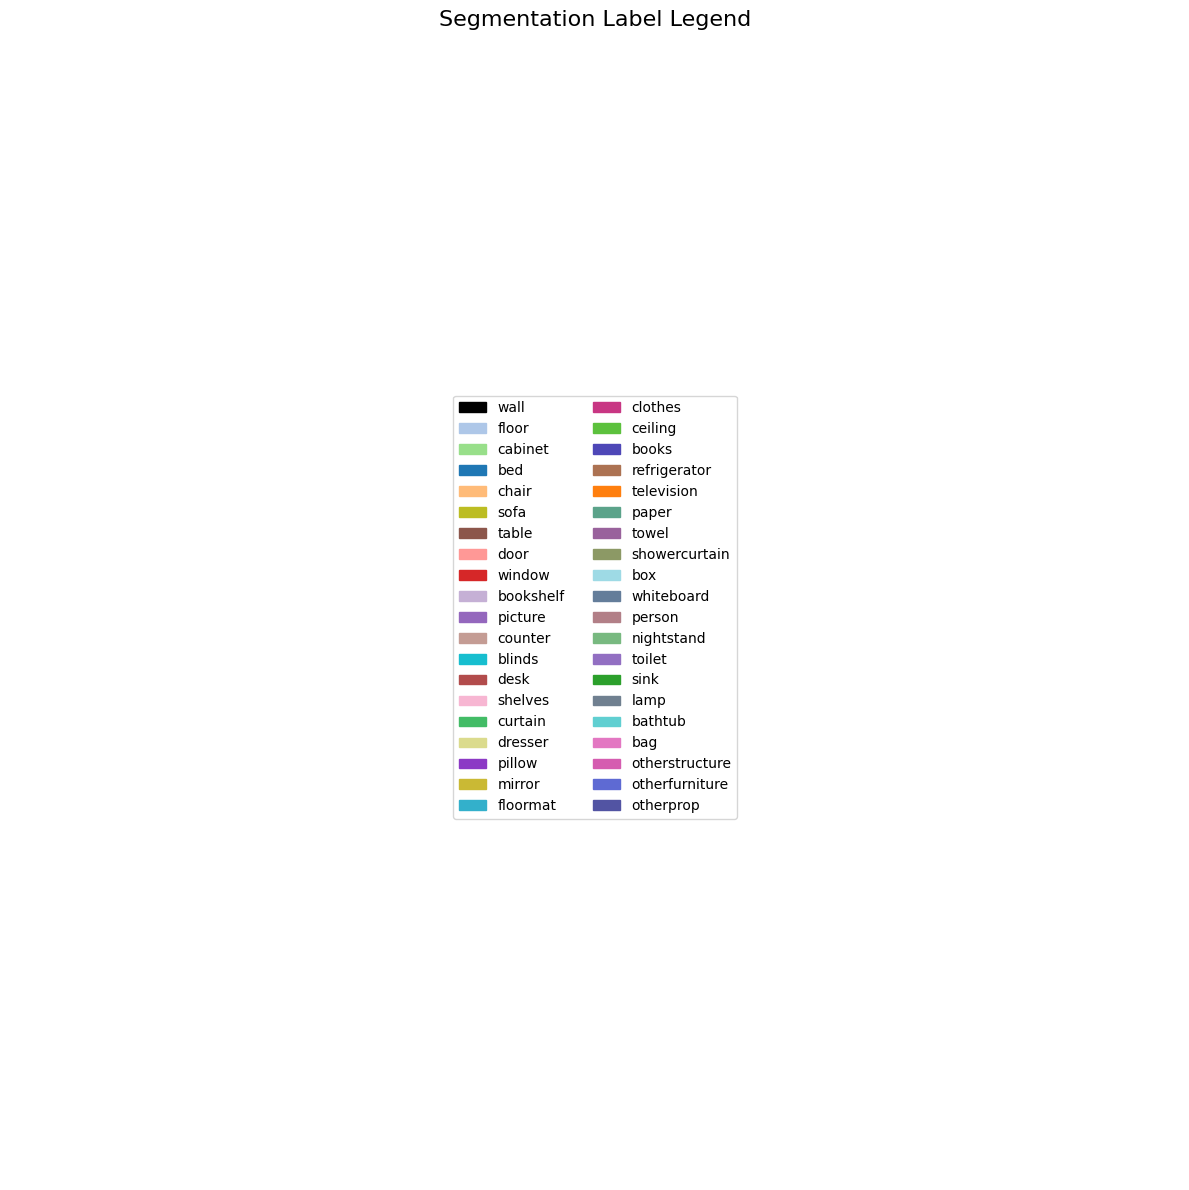

In [27]:
import matplotlib.patches as mpatches
import pandas as pd
df = pd.read_csv("./Test/nyu40_segmentation_mapping.csv")
label_names = df["name"].values[1:]  # skip header/unlabeled
label_colors = class_colors  # already loaded as np array of shape (40, 3)

# Create legend patches
legend_patches = [
    mpatches.Patch(color=np.array(color) / 255.0, label=name)
    for name, color in zip(label_names, label_colors)
]

# Show the legend in a new figure
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.title("Segmentation Label Legend", fontsize=16)
plt.legend(handles=legend_patches, loc="center", ncol=2, fontsize=10)
plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load your depth map (replace with your actual depth map)
# Depth map should be a single-channel image with depth values
depth_map = cv2.imread('Test/1001.png', cv2.IMREAD_UNCHANGED)  # or cv2.IMREAD_ANYDEPTH

# Normalize depth values to 0-1 range
normalized_depth = cv2.normalize(depth_map.astype(np.float32), None, 0.0, 1.0, cv2.NORM_MINMAX)

# Apply colormap (choose one: 'jet', 'viridis', 'plasma', 'inferno', 'magma', 'cividis')
colored_depth = plt.cm.jet(normalized_depth)[:, :, :3]  # Remove alpha channel
colored_depth = (colored_depth * 255).astype(np.uint8)

# Save the colored depth map
cv2.imwrite('colored_depth_map.png', cv2.cvtColor(colored_depth, cv2.COLOR_RGB2BGR))

True